Model: "functional_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 28, 28, 1)      │       865,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
epoch:0 d_loss:0.7084 g_loss:0.7326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:1 d_loss:0.7069 g_loss:0.7263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:2 d_loss:0.7030 g_loss:0.7219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
epoch:3 d_loss:0.7051 g_loss:0.7203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch:4 d_loss:0.7064 g_loss:0.7171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:5 d_loss:0.7088 g_loss:0.7140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:6 d_loss:0.7102 g_loss:0.7127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:7 d_loss:0.7112 g_loss:0.7088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:8 d_loss:0.7109 g_loss:0.7057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch:9 d_loss:0.7120 g_loss:0.7033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:10 d_loss:0.7123 g_loss:0.7001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:11 d_loss:0.7130 g_loss:0.6971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:12 d_loss:0.7135 g_loss:0.

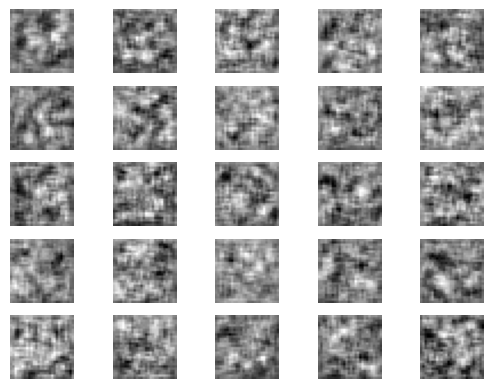

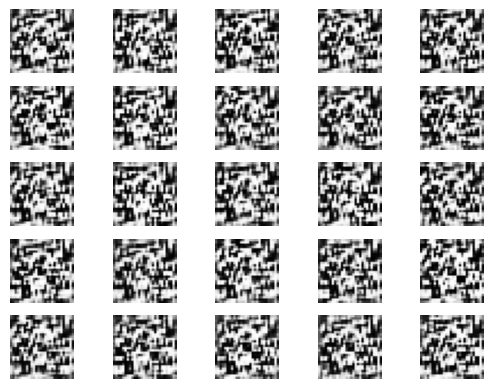

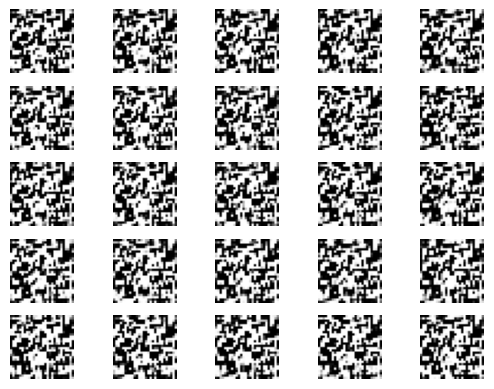

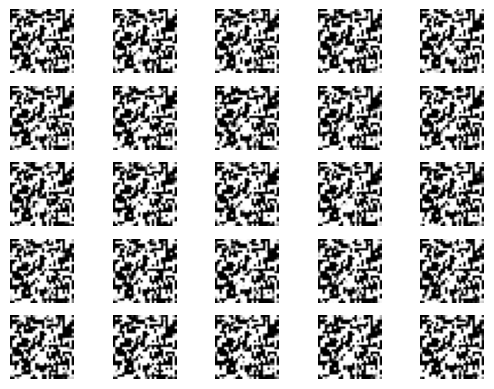

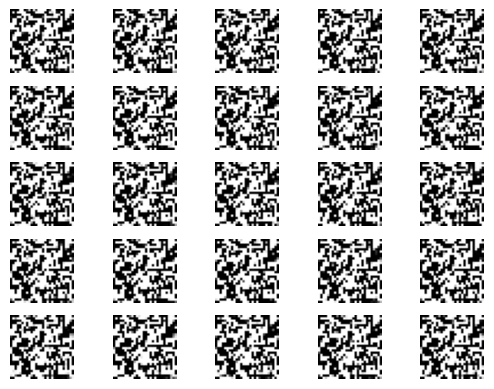

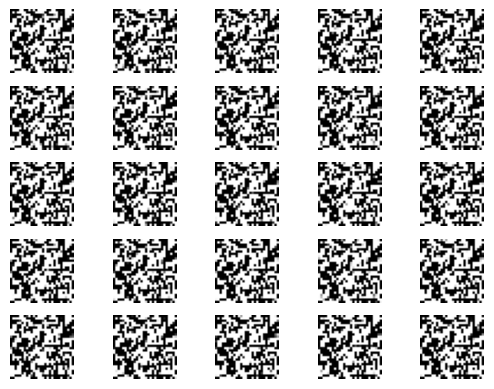

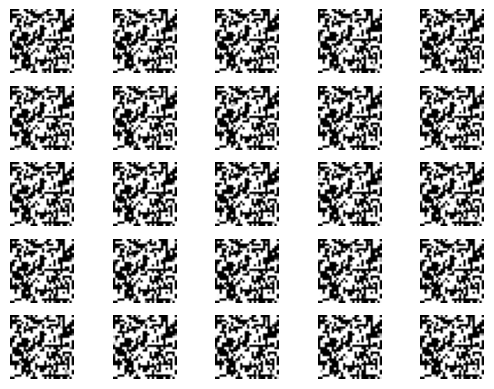

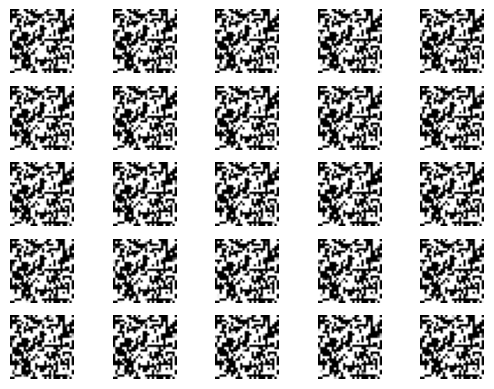

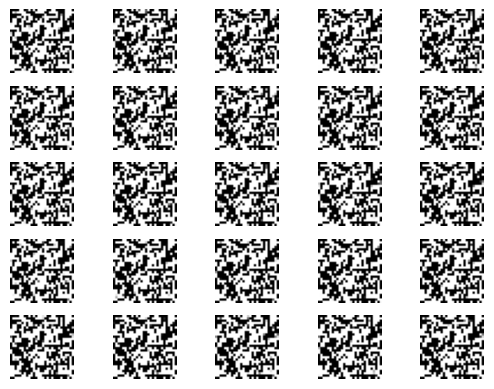

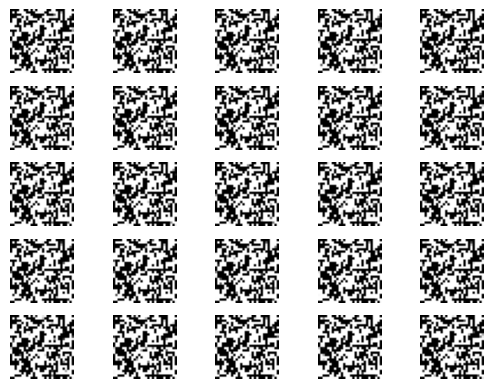

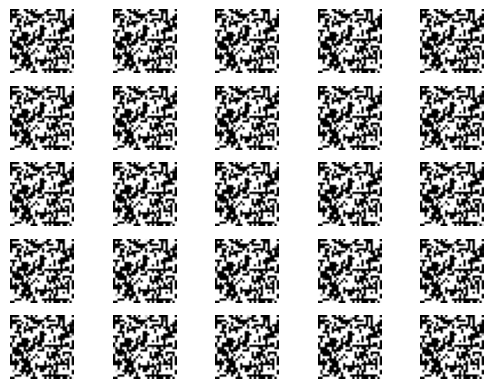

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization,Activation,LeakyReLU,UpSampling2D,Conv2D
from tensorflow.keras.models  import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

#생성자 모델을 만듦
generator=Sequential()
#128은 몇개의 노드를 중간의 은닉층에 만들것인지
#7*7은 뒤에 Upsampling이 있어서 28*28 사이즈 줄인거
#0.2는 0말고 0.2로 바꿔라
generator.add(Dense(128*7*7,input_dim=100,activation=LeakyReLU(0.2)))
#정규화
generator.add(BatchNormalization())
#일차원에서 2차원으로 바꾸는거
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
#same는 패딩을 자동으로 맞춰줘
generator.add(Conv2D(64,kernel_size=5,padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1,kernel_size=5, padding='same', activation='tanh'))

#판별자 모델을 만듦
discriminator=Sequential()
discriminator.add(Conv2D(64,kernel_size=5,strides=2,padding='same',input_shape=(28,28,1)))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False

#생성자와 판별자 모델을 연결시키는 GAN 모델을 만듦
ginput=Input(shape=(100,))
dis_output=discriminator(generator(ginput))
gan=Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy',optimizer='adam')
gan.summary()

#신경망을 실행시키는 함수 만듦
def gan_train(epoch,batch_size,saving_interval):

  #MNIST 데이터를 불러옴
  (X_train,_), (_,_)=mnist.load_data()
  X_train=X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
  X_train=(X_train-127.5)/127.5

  true=np.ones((batch_size,1))
  fake=np.zeros((batch_size,1))

  for i in range(epoch):
    #실제 데이터를 판별자에 입력하는 부분
    idx=np.random.randint(0,X_train.shape[0],batch_size)
    imgs=X_train[idx]
    d_loss_real=discriminator.train_on_batch(imgs,true)

    #가상 이미지를 판별자에 입력하는 부분
    noise=np.random.normal(0,1,(batch_size,100))
    gen_imgs=generator.predict(noise)
    d_loss_fake=discriminator.train_on_batch(gen_imgs,fake)

    #판별자와 생성자의 오차를 계산
    d_loss=0.5*np.add(d_loss_real,d_loss_fake)
    g_loss=gan.train_on_batch(noise,true)

    print('epoch:%d' %i, 'd_loss:%.4f' %d_loss, 'g_loss:%.4f' %g_loss)


    if i%saving_interval==0:
      noise=np.random.normal(0,1,(25,100))
      gen_imgs=generator.predict(noise)

      #Rescale imges 0-1
      gen_imgs=0.5*gen_imgs+0.5

      fig,axs=plt.subplots(5,5)
      count=0
      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[count, :, :, 0],cmap='gray')
          axs[j,k].axis('off')
          count+=1
      fig.savefig("./gan_mnist_%d.png"%i)

gan_train(2001,32,200)
#2000번 반복되고, 배치사이즈는 32, 200번 될때마다 결과를 저장


In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분입니다.
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인합니다.
autoencoder.summary()

In [ ]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()